<a href="https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/01_MNIST_TPU_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNIST on TPU (Tensor Processing Unit)<br>or GPU using tf.Keras and tf.data.Dataset
<table><tr><td><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/keras-tensorflow-tpu300px.png" width="300" alt="Keras+Tensorflow+Cloud TPU"></td></tr></table>


This sample trains an "MNIST" handwritten digit 
recognition model on a GPU or TPU backend using a Keras
model. Data are handled using the tf.data.Datset API. This is
a very simple sample provided for educational purposes. Do
not expect outstanding TPU performance on a dataset as
small as MNIST.

<h3><a href="https://cloud.google.com/gpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/gpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;Train on GPU or TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

  1. Select a GPU or TPU backend (Runtime > Change runtime type) 
  1. Runtime > Run All (Watch out: the "Colab-only auth" cell requires user input)

<h3><a href="https://cloud.google.com/ml-engine/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/mlengine-hexagon.png" width="50"></a>  &nbsp;&nbsp;Deploy to ML Engine</h3>
1. At the bottom of this notebook you can deploy your trained model to ML Engine for a serverless, autoscaled, REST API experience. You will need a GCP project and a GCS bucket for this last part.

TPUs are located in Google Cloud, for optimal performance, they read data directly from Google Cloud Storage (GCS)

### Parameters

In [1]:
BATCH_SIZE = 128 # On TPU, this will be the per-core batch size. A Cloud TPU has 8 cores so the global TPU batch size is 1024

training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'

### Imports

In [2]:
import os, re, math, json, shutil, pprint, time
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.python.platform import tf_logging
print("Tensorflow version " + tf.__version__)
#tf.enable_v2_behavior()

Tensorflow version 2.0.0-alpha0


In [3]:
#@title visualization utilities [RUN ME]
"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

# Matplotlib config
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  unbatched_train_ds = training_dataset.apply(tf.data.experimental.unbatch())
  
  if tf.executing_eagerly():
      for v_images, v_labels in validation_dataset:
        break

      for t_images, t_labels in unbatched_train_ds.batch(N):
        break

      validation_digits = v_images.numpy()
      validation_labels = v_labels.numpy()
      training_digits   = t_images.numpy()
      training_labels   = t_labels.numpy()
  else:
    v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
    t_images, t_labels = unbatched_train_ds.batch(N).make_one_shot_iterator().get_next()
    # Run once, get one batch. Session.run returns numpy results
    with tf.Session() as ses:
      (validation_digits, validation_labels,
       training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)
    
# utility to display training and validation curves
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.grid(linewidth=1, color='white')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

### Colab-only auth for this notebook and the TPU

In [4]:
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  auth.authenticate_user() # Authenticates the backend and also the TPU using your credentials so that they can access your private GCS buckets

### tf.data.Dataset: parse files and prepare training and validation datasets
Please read the [best practices for building](https://www.tensorflow.org/guide/performance/datasets) input pipelines with tf.data.Dataset

In [5]:
def read_label(tf_bytestring):
    label = tf.io.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label
  
def read_image(tf_bytestring):
    image = tf.io.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image
  
def load_dataset(image_file, label_file):
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset 
  
def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    #dataset = dataset.cache()  # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # Mandatory for Keras for now
    dataset = dataset.batch(batch_size, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(-1)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset
  
def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    #dataset = dataset.cache() # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

# instantiate the datasets
training_dataset = get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file, validation_labels_file)

# For TPU, we will need a function that returns the dataset
training_input_fn = lambda: get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_input_fn = lambda: get_validation_dataset(validation_images_file, validation_labels_file)

### Let's have a look at the data

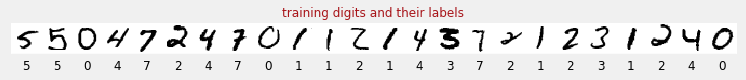

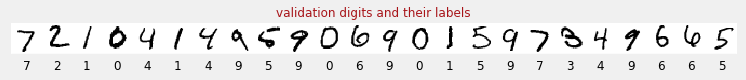

In [6]:
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "training digits and their labels", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "validation digits and their labels", N)
font_digits, font_labels = create_digits_from_local_fonts(N)

## TPU detection

In [7]:
tpu = gpus = None
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
  tf.tpu.experimental.initialize_tpu_system(tpu)
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
except ValueError:
  #gpus = tf.config.experimental.list_logical_devices("GPU")
  #if gpus:
  #  print("Running on GPU(s): ", gpus)
  #else:
  print("Running on CPU or GPU")
    
if tpu:
  strategy = tf.distribute.experimental.TPUStrategy(tpu, steps_per_run=100)
else:
  strategy = tf.distribute.get_strategy()
#elif gpus:
#  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
#else:
#  strategy = tf.distribute.OneDeviceStrategy("CPU")

Running on CPU or GPU


### Keras model: 3 convolutional layers, 2 dense layers
If you are not sure what cross-entropy, dropout, softmax or batch-normalization mean, head here for a crash-course: [Tensorflow and deep learning without a PhD](https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd/#featured-code-sample)

In [20]:
# This model trains to 99.4%— sometimes 99.5%— accuracy in 10 epochs (with a batch size of 32)

with strategy.scope():

    model = tf.keras.Sequential(
      [
        tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),

        tf.keras.layers.Conv2D(filters=6, kernel_size=3, padding='same', use_bias=False), # no bias necessary before batch norm
        tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        tf.keras.layers.Activation('relu'), # activation after batch norm

        tf.keras.layers.Conv2D(filters=12, kernel_size=6, padding='same', use_bias=False, strides=2),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(filters=24, kernel_size=6, padding='same', use_bias=False, strides=2),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(200, use_bias=False),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5), # Dropout on dense layer only

        tf.keras.layers.Dense(10, activation='softmax')
      ])

    model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# print model layers
model.summary()

# set up learning rate decay
lr_decay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.0001 + 0.02 * math.pow(0.5, 1+epoch), verbose=True)
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='gs://ml1-demo-martin/mnistlogs/log'+str(time.time()), write_graph=False, update_freq=60000)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 6)         54        
_________________________________________________________________
batch_normalization_v2_12 (B (None, 28, 28, 6)         18        
_________________________________________________________________
activation_12 (Activation)   (None, 28, 28, 6)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 12)        2592      
_________________________________________________________________
batch_normalization_v2_13 (B (None, 14, 14, 12)        36        
_________________________________________________________________
activation_13 (Activation)   (None, 14, 14, 12)       

### Train and validate the model

In [21]:
EPOCHS = 10
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print(steps_per_epoch)

# Counting steps and batches on TPU: the tpu.keras_to_tpu_model API regards the batch size of the input dataset
# as the per-core batch size. The effective batch size is 8x more because Cloud TPUs have 8 cores. It increments
# the step by +8 everytime a global batch (8 per-core batches) is processed. Therefore batch size and steps_per_epoch
# settings can stay as they are for TPU training. The training will just go faster.
# Warning: this might change in the final version of the Keras/TPU API.
  
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                            validation_data=validation_dataset, validation_steps=1, callbacks=[lr_decay, tb_callback])

468

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0101.
Epoch 1/10
  1/468 [..............................] - ETA: 30:34 - loss: 2.7546 - accuracy: 0.1172

W0611 17:56:43.971181 139620704696064 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (1.375125). Check your callbacks.


468/468 [==============================] - 16s 35ms/step - loss: 0.1403 - accuracy: 0.9576 - val_loss: 0.0545 - val_accuracy: 0.9831

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0051.
Epoch 2/10


W0611 17:56:54.145715 139620704696064 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (0.482198). Check your callbacks.


  1/468 [..............................] - ETA: 3:53 - loss: 0.0547 - accuracy: 0.9922

W0611 17:56:54.165486 139620704696064 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (0.241120). Check your callbacks.


468/468 [==============================] - 10s 21ms/step - loss: 0.0496 - accuracy: 0.9853 - val_loss: 0.0384 - val_accuracy: 0.9873

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0026.
Epoch 3/10
  1/468 [..............................] - ETA: 8s - loss: 0.0736 - accuracy: 0.9766

W0611 17:57:04.588850 139620704696064 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (0.448764). Check your callbacks.


468/468 [==============================] - 10s 20ms/step - loss: 0.0313 - accuracy: 0.9907 - val_loss: 0.0253 - val_accuracy: 0.9915

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00135.
Epoch 4/10
468/468 [==============================] - 10s 21ms/step - loss: 0.0218 - accuracy: 0.9930 - val_loss: 0.0217 - val_accuracy: 0.9920

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0007250000000000001.
Epoch 5/10
468/468 [==============================] - 9s 20ms/step - loss: 0.0166 - accuracy: 0.9952 - val_loss: 0.0193 - val_accuracy: 0.9929

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0004125.
Epoch 6/10
468/468 [==============================] - 9s 20ms/step - loss: 0.0140 - accuracy: 0.9960 - val_loss: 0.0187 - val_accuracy: 0.9932

Epoch 00007: LearningRateScheduler reducing learning rate to 0.00025625.
Epoch 7/10
468/468 [==============================] - 9s 20ms/step - loss: 0.0131 - accuracy: 0.9961 - val_loss: 0.0187 - val_accuracy

### Visualize training and validation curves

dict_keys(['loss', 'accuracy', 'val_loss', 'lr', 'val_accuracy'])


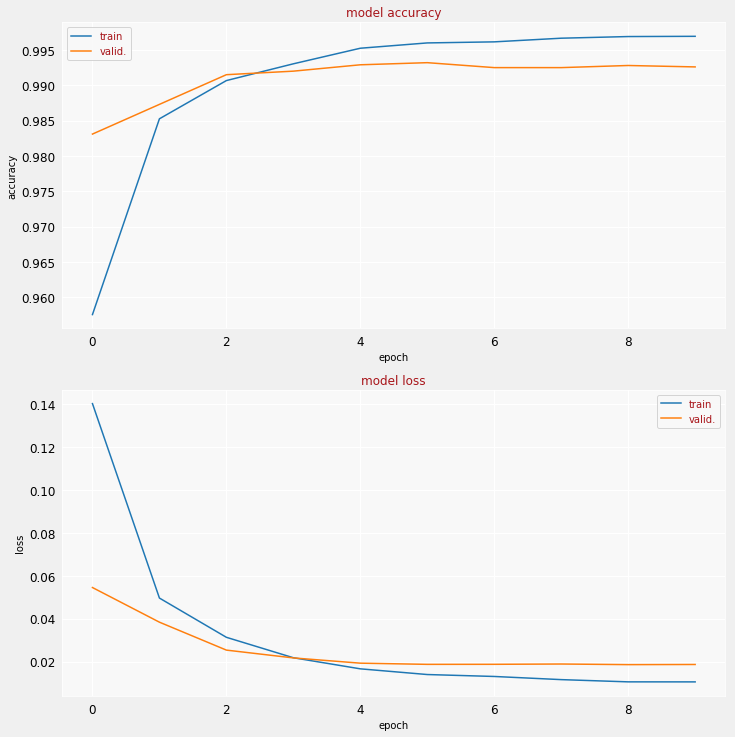

In [22]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

### Visualize predictions

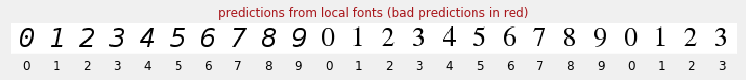

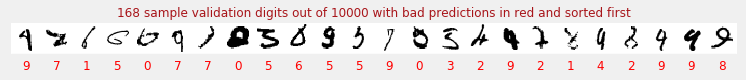

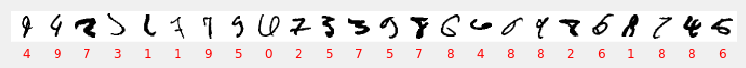

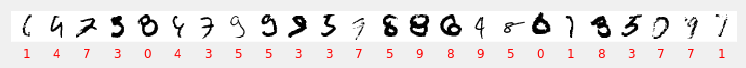

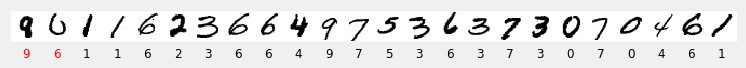

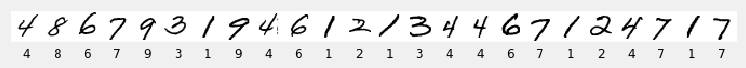

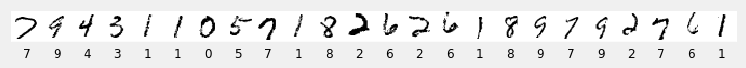

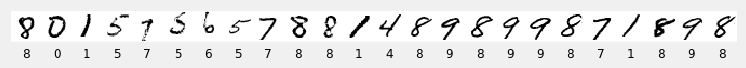

In [23]:
# recognize digits from local fonts
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

## Deploy the trained model to ML Engine

Push your trained model to production on ML Engine for a serverless, autoscaled, REST API experience.

You will need a GCS bucket and a GCP project for this.
Models deployed on ML Engine autoscale to zero if not used. There will be no ML Engine charges after you are done testing.
Google Cloud Storage incurs charges. Empty the bucket after deployment if you want to avoid these. Once the model is deployed, the bucket is not useful anymore.

### Configuration

In [ ]:
PROJECT = "" #@param {type:"string"}
BUCKET = "gs://"  #@param {type:"string", default:"jddj"}
NEW_MODEL = True #@param {type:"boolean"}
MODEL_NAME = "colabmnist" #@param {type:"string"}
MODEL_VERSION = "v0" #@param {type:"string"}

assert PROJECT, 'For this part, you need a GCP project. Head to http://console.cloud.google.com/ and create one.'
assert re.search(r'gs://.+', BUCKET), 'For this part, you need a GCS bucket. Head to http://console.cloud.google.com/storage and create one.'

### Export the model for serving from ML Engine

In [ ]:
class ServingInput(tf.keras.layers.Layer):
  # the important detail in this boilerplate code is "trainable=False"
  def __init__(self, name, dtype, batch_input_shape=None):
    super(ServingInput, self).__init__(trainable=False, name=name, dtype=dtype, batch_input_shape=batch_input_shape)
  def get_config(self):
    return {'batch_input_shape': self._batch_input_shape, 'dtype': self.dtype, 'name': self.name }

  def call(self, inputs):
    # When the deployed model is called through its REST API,
    # the JSON payload is parsed automatically, transformed into
    # a tensor and passed to this input layer. You can perform
    # additional transformations, such as decoding JPEGs for example,
    # before sending the data to your model. However, you can only
    # use tf.xxxx operations.
    return inputs

# little wrinkle: must copy the model from TPU to CPU manually. This is a temporary workaround.
tf_logging.set_verbosity(tf_logging.INFO)
restored_model = model
restored_model.set_weights(train_model.get_weights()) # this copied the weights from TPU, does nothing on GPU
tf_logging.set_verbosity(tf_logging.WARN)

# add the serving input layer
serving_model = tf.keras.Sequential()
serving_model.add(ServingInput('serving', tf.float32, (None, 28*28)))
serving_model.add(restored_model)
export_path = tf.contrib.saved_model.save_keras_model(serving_model, os.path.join(BUCKET, 'keras_export'))  # export he model to your bucket
export_path = export_path.decode('utf-8')
print("Model exported to: ", export_path)

### Deploy the model
This uses the command-line interface. You can do the same thing through the ML Engine UI at https://console.cloud.google.com/mlengine/models


In [ ]:
# Create the model
if NEW_MODEL:
  !gcloud ml-engine models create {MODEL_NAME} --project={PROJECT} --regions=us-central1

In [ ]:
# Create a version of this model (you can add --async at the end of the line to make this call non blocking)
# Additional config flags are available: https://cloud.google.com/ml-engine/reference/rest/v1/projects.models.versions
# You can also deploy a model that is stored locally by providing a --staging-bucket=... parameter
!echo "Deployment takes a couple of minutes. You can watch your deployment here: https://console.cloud.google.com/mlengine/models/{MODEL_NAME}"
!gcloud ml-engine versions create {MODEL_VERSION} --model={MODEL_NAME} --origin={export_path} --project={PROJECT} --runtime-version=1.10

### Test the deployed model
Your model is now available as a REST API. Let us try to call it. The cells below use the "gcloud ml-engine"
command line tool but any tool that can send a JSON payload to a REST endpoint will work.

In [ ]:
# prepare digits to send to online prediction endpoint
digits = np.concatenate((font_digits, validation_digits[:100-N]))
labels = np.concatenate((font_labels, validation_labels[:100-N]))
with open("digits.json", "w") as f:
  for digit in digits:
    # the format for ML Engine online predictions is: one JSON object per line
    data = json.dumps({"serving_input": digit.tolist()})  # "serving_input" because the ServingInput layer was named "serving". Keras appends "_input"
    f.write(data+'\n')

['SEQUENTIAL', '[0.9999998807907104, 7.513082631071047e-14, 1.139144067963116e-08, 3.898011064320042e-14, 1.4082402168750889e-14, 1.2195139070401897e-14, 1.4076502186100015e-09, 6.281215239774263e-13, 1.0418918172661051e-08, 7.728890949465494e-08]', '[1.2769176294114004e-07, 0.9999390840530396, 2.8117156034568325e-05, 2.037909325736109e-06, 3.2849829523229346e-08, 3.794116878452769e-07, 1.2950034100622787e-10, 3.0006724045961164e-05, 2.5415941573569967e-10, 2.944753418887558e-07]', '[5.513777767696126e-10, 4.462803016025418e-09, 0.9999988079071045, 2.5445606866014714e-07, 3.362800218408707e-13, 3.4929680675643837e-12, 1.970903258305401e-12, 1.0858573062932919e-07, 8.707166898602736e-07, 1.5860496249686662e-09]', '[1.2159731028563858e-16, 3.6171125773407087e-13, 8.479520118833891e-14, 1.0, 1.7065597338781782e-18, 4.052971847023912e-11, 2.5456686010569502e-18, 1.1113750978536396e-12, 3.3342556146620517e-13, 3.0945648062281894e-13]', '[1.3914041030460567e-09, 6.120958406796717e-09, 5.2561

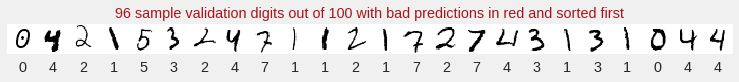

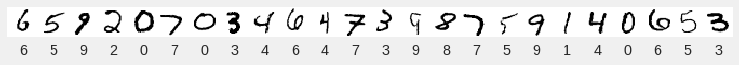

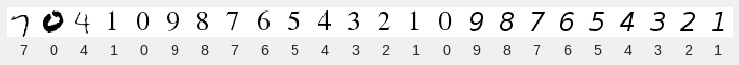

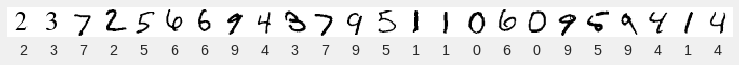

In [ ]:
# Request online predictions from deployed model (REST API) using the "gcloud ml-engine" command line.
predictions = !gcloud ml-engine predict --model={MODEL_NAME} --json-instances digits.json --project={PROJECT} --version {MODEL_VERSION}
print(predictions)

probabilities = np.stack([json.loads(p) for p in predictions[1:]]) # first line is the name of the input layer: drop it, parse the rest
predictions = np.argmax(probabilities, axis=1)
display_top_unrecognized(digits, predictions, labels, N, 100//N)

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2018 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
